In [32]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np

In [29]:
weather = pd.read_csv('weather.csv', names=['date', 'avgTa', 'minTa', 'minTaHrmt', 'maxTa', 'maxTaHrmt', 'mi10MaxRn', 'mi10MaxRnHrmt', 'hr1MaxRn', 'hr1MaxRnHrmt', 'sumRnDur', 'sumRn', 'maxInsWs', 'maxInsWsWd', 'maxInsWsHrmt', 'maxWs', 'maxWsWd', 'maxWsHrmt', 'avgWs', 'hr24SumRws', 'maxWd', 'avgTd', 'minRhm', 'minRhmHrmt', 'avgRhm', 'avgPv', 'avgPa', 'maxPs', 'maxPsHrmt', 'minPs', 'minPsHrmt', 'avgPs', 'ssDur', 'sumSsHr', 'hr1MaxIcsrHrmt', 'hr1MaxIcsr', 'sumGsr', 'ddMefs', 'ddMefsHrmt', 'ddMes', 'ddMesHrmt', 'sumDpthFhsc', 'avgTca', 'avgLmac', 'avgTs', 'minTg', 'avgCm5Te', 'avgCm10Te', 'avgCm20Te', 'avgCm30Te', 'avgM05Te', 'avgM10Te', 'avgM15Te', 'avgM30Te', 'avgM50Te', 'sumLrgEv', 'sumSmlEv', 'n99Rn', 'iscs', 'sumFogDur'])
weather = weather.drop(['iscs'], axis = 1)
weather.set_index('date', inplace=True)
weather.head(1)

,avgTa,minTa,minTaHrmt,maxTa,maxTaHrmt,mi10MaxRn,mi10MaxRnHrmt,hr1MaxRn,hr1MaxRnHrmt,sumRnDur,sumRn,maxInsWs,maxInsWsWd,maxInsWsHrmt,maxWs,maxWsWd,maxWsHrmt,avgWs,hr24SumRws,maxWd,avgTd,minRhm,minRhmHrmt,avgRhm,avgPv,avgPa,maxPs,maxPsHrmt,minPs,minPsHrmt,avgPs,ssDur,sumSsHr,hr1MaxIcsrHrmt,hr1MaxIcsr,sumGsr,ddMefs,ddMefsHrmt,ddMes,ddMesHrmt,sumDpthFhsc,avgTca,avgLmac,avgTs,minTg,avgCm5Te,avgCm10Te,avgCm20Te,avgCm30Te,avgM05Te,avgM10Te,avgM15Te,avgM30Te,avgM50Te,sumLrgEv,sumSmlEv,n99Rn,sumFogDur
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-05,13.3,8.5,537,18.4,1555,0,0,0.0,0,0.0,0.0,10.0,320,1524,5.1,290,1352,2.5,2181,270,4.8,40,1410,57.3,8.6,1007.9,1020.5,2310,1016.1,1,1018.2,11.6,10.5,1200,2.92,19.44,0.0,0,0.0,0,0.0,2.3,0.4,14.5,2.9,17.3,17.4,18.6,19.9,20.9,22.3,22.8,21.5,18.3,3.6,5.1,0.0,0.0


In [30]:
confirmed = pd.read_csv('covid-confirmed-in-seoul.csv', names=['date', 'confirmed'])
confirmed.set_index('date', inplace=True)
confirmed.head(1)

,confirmed
date,
2021-10-05,521


In [33]:
df = pd.merge(weather, confirmed, how='inner', on='date')
train, test= train_test_split(df, random_state=42)
train.shape, test.shape

((275, 59), (92, 59))

In [34]:
target = 'confirmed' 
features = df.columns.drop('confirmed')

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [35]:
train_ds = lgb.Dataset(X_train, label = y_train) 
test_ds = lgb.Dataset(X_test, label = y_test)

In [36]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [37]:
model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 14757.3
[200]	valid_0's l2: 8246.26
[300]	valid_0's l2: 6750.53
[400]	valid_0's l2: 6415.47
[500]	valid_0's l2: 6121.39
[600]	valid_0's l2: 5961.06
[700]	valid_0's l2: 5891.69
[800]	valid_0's l2: 5845.78
[900]	valid_0's l2: 5805.4
[1000]	valid_0's l2: 5764.09
Did not meet early stopping. Best iteration is:
[987]	valid_0's l2: 5760.11


In [38]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [40]:
mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)
print('Mean squared error: ', mse)
print('R2 score: ', r2)

Mean squared error:  5760.105414162952
R2 score:  0.8895404425391291


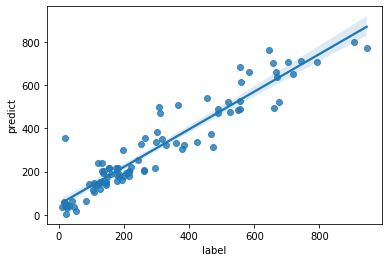

In [43]:
final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)
final_result.columns = ['label','predict']
sns.regplot(x = 'label', y = 'predict', data = final_result);